# <center>Hybrid GAN </center>
## <center>AutoEncoder + GAN</center>

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# creating minibatches
def mini_batch(X, size):
    # generate random integers of shape size*1 and in range 0 to len(X)
    # treat x_bat as indices and return values from X at those indices
    x_bat = X[np.random.randint(len(X), size = (size,1))]
    x_bat = x_bat.reshape(size, X.shape[1], X.shape[2], X.shape[3])
    
    return x_bat

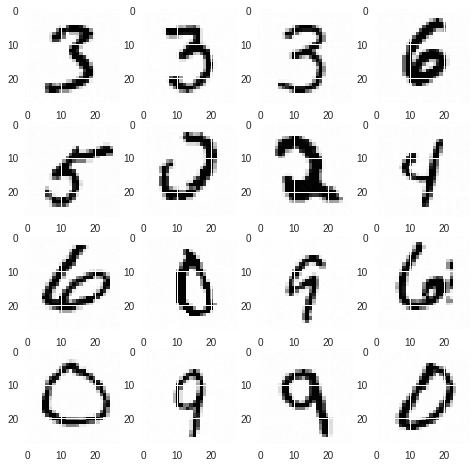

In [109]:
# importing dataset
image_data = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = image_data.load_data()

"""
# selecting only one class
seven_digits_train = np.where(y_train==7)
x_train = x_train[seven_digits_train]

seven_digits_test = np.where(y_test==7)
x_test = x_test[seven_digits_test]


"""


x_train = x_train + np.random.normal(0,1,x_train.shape)
x_test = x_test + np.random.normal(0,1,x_test.shape)

# shuffling
np.random.shuffle(x_train)
np.random.shuffle(x_test)

# plotting a random sample from x_train
fig = plt.figure(figsize=(8,8))


col = 4
row = 4
j = 0

for i in range(1, row*col+1):
    fig.add_subplot(row, col, i)
    plt.imshow(x_train[j])
    j+=8
plt.show()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test  = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [0]:
tf.reset_default_graph()

D_in = tf.placeholder(tf.float32, [None, 28,28,1], name="D_in")
X_in = tf.placeholder(tf.float32, [None, 28,28,1])
G_in = tf.placeholder(tf.float32, [None, 28,28,1], name="G_in")
D_label = tf.placeholder(tf.float32, [None, 1])
G_label = tf.placeholder(tf.float32, [None, 1])

with tf.device("/gpu:0"):
    def Generator(z):
        global print_flag_gen
        """
            z    : Tensor holds noise sample
        """
        g_conv6 = tf.nn.leaky_relu(tf.layers.conv2d(filters=128, inputs=z, kernel_size=(5,5), strides=(2,2), 
                                  padding="same", kernel_initializer=tf.initializers.random_normal), 0.2)
        g_conv7 = tf.nn.leaky_relu(tf.layers.conv2d(g_conv6, filters=256, kernel_size=(5,5), strides=(2,2), 
                                  padding="same", kernel_initializer=tf.initializers.random_normal), 0.2)
        
        g_conv8 = tf.nn.leaky_relu(tf.layers.conv2d(g_conv7, filters=512, kernel_size=(5,5), strides=(2,2), 
                                  padding="same", kernel_initializer=tf.initializers.random_normal), 0.2)
        
        #g_conv1 = tf.nn.leaky_relu(tf.layers.conv2d_transpose(g_conv8, 1024, kernel_size=(4,4),strides=(2,2),padding="same", 
        #                                     kernel_initializer=tf.initializers.random_normal), 0.2)
        #g_norm1 = tf.layers.batch_normalization(g_conv1)
    
        g_conv2 = tf.nn.leaky_relu(tf.layers.conv2d_transpose(g_conv8, 512, kernel_size=(5,5), strides=(2,2), padding="same",
                                             kernel_initializer=tf.initializers.random_normal), 0.2)
        g_resi1 = tf.image.resize_images(g_conv2, size = (7,7), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        g_norm2 = tf.layers.batch_normalization(g_resi1)
    
        g_conv3 = tf.nn.leaky_relu(tf.layers.conv2d_transpose(g_norm2, 256, kernel_size=(5,5), strides=(2,2), padding="same",
                                             kernel_initializer=tf.initializers.random_normal), 0.2)
        g_norm3 = tf.layers.batch_normalization(g_conv3)
    
        g_conv4 = tf.nn.leaky_relu(tf.layers.conv2d_transpose(g_norm3, 128, kernel_size=(5,5), strides=(2,2), padding="same",
                                             kernel_initializer=tf.initializers.random_normal), 0.2)
        g_norm4 = tf.layers.batch_normalization(g_conv4)
    
        g_conv5 = tf.nn.tanh(tf.layers.conv2d_transpose(g_norm4, 1, kernel_size=(5,5), strides=(1,1), padding="same",
                                             kernel_initializer=tf.initializers.random_normal))
    
        if print_flag_gen == True:
            print("Input            : ",z.shape)
            print("g_conv6          : ",g_conv6.shape)
            print("g_conv7          : ",g_conv7.shape)
            print("g_conv8          : ",g_conv8.shape)
            #print("g_conv1          : ",g_norm1.shape)
            print("g_conv2          : ",g_norm2.shape)
            print("g_conv3          : ",g_norm3.shape)
            print("g_conv4          : ",g_norm4.shape)
            print("generator        : ",g_conv5.shape)
            print_flag_gen = False
        
        return g_conv5

In [0]:
with tf.device("/gpu:0"):
    def Discriminator(D_input, train_flag):
        global print_flag_dis
        """
            D_input    : Tensor holds image data
            train_flag : if True, the layers will be trainable, untrainable otherwise
        """
        
        d_conv1 = tf.nn.leaky_relu(tf.layers.conv2d(filters=128, inputs=D_input, trainable=train_flag, kernel_size=(4,4), strides=(2,2), 
                                  padding="same", kernel_initializer=tf.initializers.random_normal), 0.2)
        d_norm1 = tf.layers.batch_normalization(d_conv1)
        
        
        d_conv2 = tf.nn.leaky_relu(tf.layers.conv2d(d_norm1, 256, kernel_size=(2,2), trainable=train_flag, strides=(2,2), padding="same",
                                  kernel_initializer=tf.initializers.random_normal), 0.2)
        d_norm2 = tf.layers.batch_normalization(d_conv2)
        
        
        d_conv3 = tf.nn.leaky_relu(tf.layers.conv2d(d_norm2, 512, kernel_size=(2,2), trainable=train_flag, strides=(2,2), padding="same",
                                  kernel_initializer=tf.initializers.random_normal), 0.2)
        d_norm3 = tf.layers.batch_normalization(d_conv3)
        
        
        d_conv4 = tf.nn.leaky_relu(tf.layers.conv2d(d_norm3, 1024, kernel_size=(2,2), trainable=train_flag, strides=(2,2), padding="same",
                                   kernel_initializer=tf.initializers.random_normal), 0.2)
        d_norm4 = tf.layers.batch_normalization(d_conv4)
        
        
        d_conv5 = tf.nn.leaky_relu(tf.layers.conv2d(d_norm4, 1, kernel_size=(2,2), trainable=train_flag, strides=(2,2), padding="same",
                                   kernel_initializer=tf.initializers.random_normal), 0.2)
        
        flat = tf.layers.flatten(d_conv5)
        
        discriminator = tf.nn.sigmoid(tf.layers.dense(flat, 1, trainable=train_flag))
        
        if print_flag_dis == True:
            print("input            : ", D_input.shape)
            print("conv_block_1     : ", d_conv1.shape)
            print("conv_block_2     : ", d_conv2.shape)
            print("conv_block_3     : ", d_conv3.shape)
            print("conv_block_4     : ", d_conv4.shape)
            print("conv_block_5     : ", d_conv5.shape)
            print("Discriminator    : ", discriminator.shape)
            print_flag_dis = False
            
        return discriminator

In [112]:
print_flag_dis = True
print_flag_gen = True
# to avoid initialization errors generator and discriminator functions are called before tf.global_variables_initializer()
# G_z stands for G(z)
# D_G_z_T stands for D(G(z)) with F means train_flag is False and T means train_flag is True
print("Generator: ")
G_z = Generator(G_in)
print("\n\nDiscriminator: ")
D_fake = Discriminator(G_z, train_flag=False)
D_real = Discriminator(D_in, train_flag=True)

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake)))
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real)))
d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))

g_se  = tf.reduce_mean(tf.squared_difference(G_z, X_in) )

g_ops = tf.train.AdamOptimizer(0.0001,beta1=0.5).minimize(g_loss)
g_ops_se = tf.train.AdamOptimizer(0.01).minimize(g_se)
d_ops = tf.train.AdamOptimizer(0.00001, beta1=0.5).minimize(d_loss)

Generator: 
Input            :  (?, 28, 28, 1)
g_conv6          :  (?, 14, 14, 128)
g_conv7          :  (?, 7, 7, 256)
g_conv8          :  (?, 4, 4, 512)
g_conv2          :  (?, 7, 7, 512)
g_conv3          :  (?, 14, 14, 256)
g_conv4          :  (?, 28, 28, 128)
generator        :  (?, 28, 28, 1)


Discriminator: 
input            :  (?, 28, 28, 1)
conv_block_1     :  (?, 14, 14, 128)
conv_block_2     :  (?, 7, 7, 256)
conv_block_3     :  (?, 4, 4, 512)
conv_block_4     :  (?, 2, 2, 1024)
conv_block_5     :  (?, 1, 1, 1)
Discriminator    :  (?, 1)


In [0]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(tf.global_variables_initializer())

# hyperparameters
sample_size = 64
epochs = 2001
noise_sample_len = tf.shape(G_in)[1]

g_l = []
g_l_se = []
d_l = []


# here goes the training
for i in range(epochs):
    
    for j in range(1):
        # create noise sample
        noise = np.random.normal(0, 1,[sample_size, 28,28,1])
        # create sample of real images
        real_imgs = mini_batch(x_train, sample_size)/255.0
        
        # train the discriminator
        sess.run(d_ops, {D_in: real_imgs, G_in: noise})
        d_l.append(sess.run(d_loss, {D_in: real_imgs, G_in: noise}))
    
    # train the generator
    
    for k in range(1):
        sess.run(g_ops_se, {G_in: noise, X_in: real_imgs})
        g_l_se.append(sess.run(g_se, {G_in: noise, X_in: real_imgs}))
        sess.run(g_ops, {G_in: noise})
        g_l.append(sess.run(g_loss, {G_in: noise}))

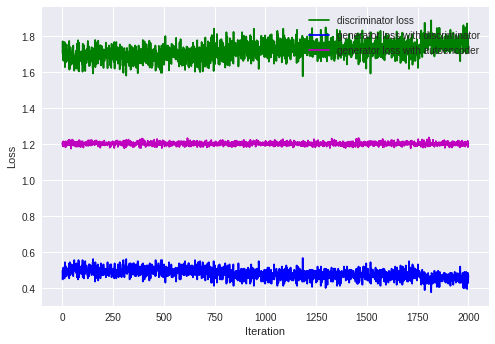

In [114]:
# plotting loss
plt.plot(range(0,len(d_l)), d_l, 'g', label='discriminator loss')
plt.plot(range(0,len(g_l)), g_l, 'b', label='generator loss with discriminator')
plt.plot(range(0,len(g_l_se)), g_l_se, 'm', label='generator loss with autoencoder')
plt.legend(loc='upper right')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

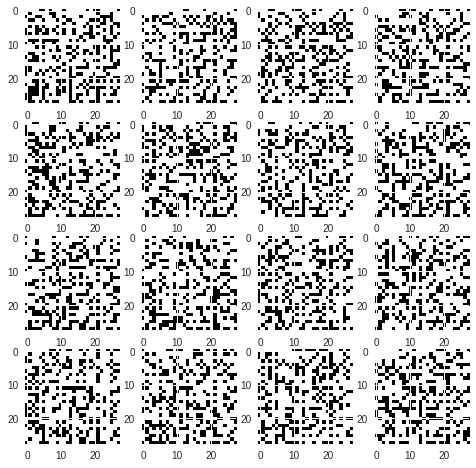

In [115]:
pred = sess.run(G_z, {G_in: np.random.normal(0, 1,[sample_size, 28,28,1])})
pred = pred.reshape(sample_size, 28,28)
fig2 = plt.figure(figsize=(8,8))

col = 4
row = 4
j = 0

for i in range(1, row*col+1):
    fig2.add_subplot(row, col, i)
    plt.imshow(pred[j])
    j+=1
plt.show()

##Resources     

* https://arxiv.org/abs/1406.2661
* https://arxiv.org/abs/1511.06434
* https://github.com/jacobgil/keras-dcgan/blob/master/dcgan.py
* https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9
* https://github.com/soumith/ganhacks
* https://github.com/znxlwm/tensorflow-MNIST-GAN-DCGAN
* https://julianzaidi.wordpress.com/2017/04/24/deep-convolution-gan-dcgan-architecture-and-training/
* https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/
